In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jedi.inference.gradual.typing import Tuple
from tensorboard.notebook import display

from farich_functions import *

In [2]:
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['font.size'] = 16

In [4]:
datadir = 'data'

In [5]:
# filepath = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_no.root')
# filepath_fixed = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_fixed.root')
# filepath_fixed = os.path.join(datadir, 'fullsim_optical_10000_pi_500_1500_FARICH_35mm_no.root')
filepath_fixed = os.path.join(datadir, 'fullsim_optical_10000_pi_500_1500_FARICH_35mm_no_no_trackers.root')
filepath_low_energies = os.path.join(datadir, 'fullsim_optical_10000_pi_500_800_FARICH_35mm_no_no_trackers.root')
# filepath_monodir = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_monodir_no.root')
filepath_monodir = os.path.join(datadir, 'fullsim_optical_10000_pi_1500_monodir_FARICH_no.root')
filepath_binned = os.path.join(datadir, 'fullsim_optical_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root')
# filepath_2pi = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_2pi_phi.root')
# filepath_prototype = os.path.join(datadir, 'farichsim_10kevt.root')
# filepath_new = os.path.join(datadir, 'fullsim_optical_1000_pi_1500_spectre_test_3.root')

In [6]:
# file = uproot.open(filepath)
file = uproot.open(filepath_fixed)
file_low= uproot.open(filepath_low_energies)
# file = uproot.open(filepath_monodir)
# file_2pi = uproot.open(filepath_2pi)
# file_prototype = uproot.open(filepath_prototype)
# file_new = uproot.open(filepath_new)

In [7]:
plt.style.use('default')

In [8]:
int(str(file.keys()[0]).split(';')[1][:-1])

9

In [9]:
# plot_cyl(file, transposed=True)

# Main (tmp obv)

In [10]:
rng = np.random.default_rng(12345)
def addNoise(idf:pd.DataFrame, edf:pd.DataFrame, bdf: pd.DataFrame, noiseTimeRange: Tuple, noisefreqpersqmm, shiftSignalTimes=True):
    x_grid = np.arange(-250, 250, SIPM_CELL_SIZE)
    y_grid = np.arange(-250, 250, SIPM_CELL_SIZE)
    
    nevents = bdf.shape[0]
    munoise = (noiseTimeRange[1]-noiseTimeRange[0])*1e-9*noisefreqpersqmm*(500**2)

    print(f'    Generate noise with DCR per mm^2 {noisefreqpersqmm}, mean number of hits per event: {munoise:.2f}.', end='\n')

    noisehits = rng.poisson(munoise, nevents)   # генерация массива числа шумовых срабатываний в событиях по пуассоновскому распределению
    Ndc = int(noisehits.sum())                  # общее число шумовых срабатываний (скаляр)
    signalhits = bdf['nhits']   # массив числа сигнальных срабатываний по событиям

    # случайное смещение сигнальных срабатываний в пределах временного окна генерации шума
    if shiftSignalTimes:
      edf['t_c'] += np.repeat(rng.uniform(0, noiseTimeRange[1]-2, nevents), bdf['nhits'])

    edf['signal'] = np.ones(signalhits.sum(), bool)  # разметка сигнальных срабатываний значением 'signal' True
    if Ndc == 0:    # если нет шумовых срабатываний
      return edf  # возвращаем исходный датафрейм с добавлением колонки 'signal'

    xich = rng.choice(x_grid.size, Ndc)           # генерация случайных номеров сработавших каналов с возможным повтором
    yich = rng.choice(y_grid.size, Ndc)           # генерация случайных номеров сработавших каналов с возможным повтором

    xh = x_grid[xich]                             # x-координата сработавших каналов
    yh = y_grid[yich]                             # y-координата сработавших каналов
    zh = 2000.0                                   # z-координата срабатываний (скаляр)
    th = rng.uniform(noiseTimeRange[0], noiseTimeRange[1], size=Ndc) # генерация времён срабатываний по однородному распределению

    # нумерация шумовых срабатываний по событиям
    ievent = np.repeat(bdf.index, noisehits)     # массив номеров событий для записи в датафрейм
    ihit = np.zeros(Ndc, 'int64')               # инициализация массива номеров срабатываний для записи в датафрейм
    index = 0
    for i in range(nevents):
      ihit[index:index+noisehits[i]] = signalhits[i] + np.arange(noisehits[i])
      index += noisehits[i]

    # создание датафрейма с шумовыми срабатываниями того же формата, что hitdf
    noisedf = pd.DataFrame({'x_cn': xh, 'y_cn': yh, 'z_c': zh, 't_c': th, 'signal': np.zeros(Ndc, bool)},
                           index=pd.MultiIndex.from_arrays((ievent, ihit), names=('entry', 'subentry')))

    # TO DO: случайное смещение кольца в фотодетекторе (сдвиг координат сигнальных хитов).
    # Сложность с реализацией для неравномерной сетки пикселей, т.к. зазоры между матрицами больше зазоров между пикселями в матрице.
    # Проще сделать в моделировании.

    # сливаем сигнальный и шумовой датафрейм и сортируем указатель событий и срабатываний
    hitdf2 = pd.concat((edf, noisedf), copy=False).sort_index(level=('entry', 'subentry'))
    
    columns_to_fill = ['x_i', 'y_i', 'true_p', 'beta', 'x_p', 'y_p', 'z_p', 'nx_p', 'ny_p', 'nz_p']
    
    hitdf2[columns_to_fill] = hitdf2.groupby(level='entry')[columns_to_fill].apply(lambda group: group.ffill()).reset_index(level=0, drop=True)
    
    hitdf2['x_c'] = hitdf2.groupby(level='entry').apply(
    lambda group: group['x_c'].combine_first(
        group['x_cn'] + group['x_i']
    )).reset_index(level=0, drop=True)
    hitdf2['y_c'] = hitdf2.groupby(level='entry').apply(
    lambda group: group['y_c'].combine_first(
        group['y_cn'] + group['y_i']
    )).reset_index(level=0, drop=True)
    
    hitdf2.drop(['x_cn', 'y_cn'], axis=1, inplace=True)
    
    # обновляем количества срабатываний в partdf, добавляя количества шумовых срабатываний по событиям
    bdf['sum_hits'] = bdf['nhits'] + noisehits

    return hitdf2


In [11]:
def init_sipm_eff():
    pdes_tmp = pd.read_csv('PDE.csv', sep=';', names=['A'])
    t1 = []
    t2 = []
    for inedx, row in pdes_tmp.iterrows():
        t1.append(float(row['A'].split(';')[0].replace(',', '.')))
        t2.append(float(row['A'].split(';')[1].replace(',', '.')))
    PDE_wvs = np.linspace(200, 900, 128)
    PDEs = np.interp(PDE_wvs, t1, t2, left=0, right=0)
    sipm_eff = fix_PDE_plot(PDEs, PDE_wvs)
    return sipm_eff, PDE_wvs

In [12]:
idf = pd.DataFrame()
idf['W'] = [35.]
# idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [205.] # 200
idf['n_mean'] = [1.04511]
# 
# idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]

In [13]:
sipm_eff, PDE_wvs = init_sipm_eff()

In [14]:
max(sipm_eff.values())

0.55414

максисмальное значение в старом моделировании - 38%

In [15]:
for key in sipm_eff.keys():
    sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

In [16]:
max(sipm_eff.values())

0.38

In [17]:
x_grid = np.arange(-3*norm_r * np.sin(np.pi / 27), 3*norm_r * np.sin(np.pi / 27), SIPM_CELL_SIZE)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

In [18]:
def init_coords(file, MAXIMUM_EVENT_GROUP_NUMBER):
    x = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.x'].array())
    y = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.y'].array())
    z = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.postStepPosition.z'].array())
    wvs = 1239.841 / np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['FarichBarrelG4Hits.energy'].array()) * 1e-9
    x3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.px'].array())
    y3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.py'].array())
    z3 = np.array(file[f'events;{MAXIMUM_EVENT_GROUP_NUMBER}']['allGenParticles.core.p4.pz'].array())
    true_direction_coordinates = np.column_stack((x3, y3, z3))
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs))
    return coordinates, true_direction_coordinates

In [19]:
filepath_binned = os.path.join(datadir, f'fullsim_optical_2000_pi_bin_{1}_FARICH_35mm_no_no_trackers.root')
file_binned = uproot.open(filepath_binned)
coordinates, true_direction_coordinates = init_coords(file_binned, int(str(file_binned.keys()[0]).split(';')[1][:-1]))
for i in range(2, 11):
    filepath_binned = os.path.join(datadir, f'fullsim_optical_2000_pi_bin_{i}_FARICH_35mm_no_no_trackers.root')
    file_binned = uproot.open(filepath_binned)
    coordinates_i, true_direction_coordinates_i = init_coords(file_binned, int(str(file_binned.keys()[0]).split(';')[1][:-1]))
    coordinates = np.concatenate((coordinates, coordinates_i), axis=0)
    true_direction_coordinates = np.concatenate((true_direction_coordinates, true_direction_coordinates_i), axis=0)

In [20]:
# coordinates = np.column_stack((x, y, z, wvs))

coordinates.shape

(20000, 4)

In [21]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)

In [22]:
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
# drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
# tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)
print(coordinates.shape)
# print(drift_chamber_coordinates.shape)
# print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(19988, 4)
(19988, 3)


In [23]:
# ev = 123
# plot_event(coordinates[ev], None, None, np.stack([np.concatenate(true_direction_coordinates[ev]), np.concatenate(true_direction_coordinates[ev] * 3000)], axis=1))
# То есть есть события, когда направление первичной частицы не попадает в кольцо. Почему?


In [24]:
sipm_sim(coordinates, sipm_eff)

In [25]:
# plot_cyl(file, coordinates, True)

In [26]:
idx_to_drop = []
for i in range(coordinates.shape[0]):
    if coordinates[i][0].shape[0] == 0:
        idx_to_drop.append(i)
coordinates = np.delete(coordinates, idx_to_drop, axis=0)
# drift_chamber_coordinates = np.delete(drift_chamber_coordinates, idx_to_drop, axis=0)
# tpc_coordinates = np.delete(tpc_coordinates, idx_to_drop, axis=0)
true_direction_coordinates = np.delete(true_direction_coordinates, idx_to_drop, axis=0)

print(coordinates.shape)
# print(drift_chamber_coordinates.shape)
# print(tpc_coordinates.shape)
print(true_direction_coordinates.shape)

(19871, 4)
(19871, 3)


In [27]:
main_angles = rotate_lines(true_direction_coordinates)

In [28]:
intersections = find_intersections(true_direction_coordinates)

[array([0.00120069]) array([0.38860658]) array([0.35055417])]


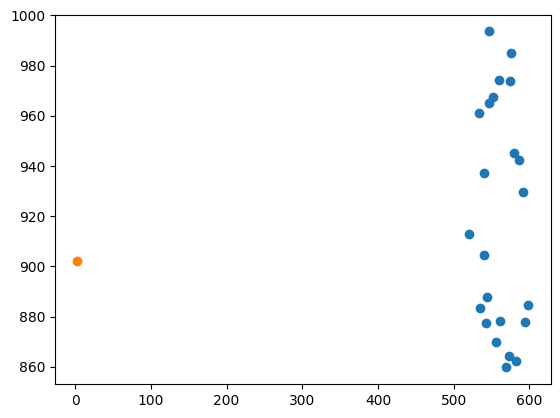

In [29]:

num = 30 # unturned events
# plt.scatter(rotate_event(coordinates[0], main_angles[0])[:,0], rotate_event(coordinates[0], main_angles[0])[:,2])
plt.scatter(coordinates[num][0], coordinates[num][2])
plt.scatter(intersections[num][0], intersections[num][2])
print(true_direction_coordinates[num])
plt.show()

In [30]:
rotate_events(coordinates, main_angles)

In [31]:
# plot_cyl(file, coordinates)

In [32]:
move_events_to_grid(coordinates, grid)

In [33]:
# plot_cyl(file, coordinates, True)

In [34]:
# r_c = (coordinates[:,0] - intersections[:,0]) ** 2 + (coordinates[:,1] - intersections[:,1]) ** 2

In [35]:
repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])

In [36]:
edf = pd.DataFrame(coordinates, columns=['x_c', 'y_c', 'z_c', 'wv_c'])
# edf['r_c'] = r_c

In [37]:
unraveled_data = {col: [] for col in edf.columns}
row_indices = []

# Iterate over the DataFrame and unravel the arrays
for i, row in edf.iterrows():
    max_length = max(len(row[col]) for col in edf.columns)
    for k in range(max_length):
        row_indices.append((i, k))
        for col in edf.columns:
            if k < len(row[col]):
                unraveled_data[col].append(row[col][k])
            else:
                unraveled_data[col].append(np.nan)  # Handle cases where arrays are of different lengths

# Create a new DataFrame from the unraveled data
unraveled_df = pd.DataFrame(unraveled_data)

# Create a MultiIndex for the rows
multi_index = pd.MultiIndex.from_tuples(row_indices, names=['entry', 'subentry'])
unraveled_df.index = multi_index


In [38]:
# unraveled_df['r_c'] = np.sqrt(unraveled_df.r_c)

In [39]:
edf = unraveled_df

In [40]:
edf['x_i'] = np.repeat(intersections[:,0], repeat_nums, axis=0)
edf['z_i'] = np.repeat(intersections[:,2], repeat_nums, axis=0)

In [41]:
x = y = z = x3 = y3 = z3 = unraveled_data = row_indices = main_angles = intersections = wvs = coordinates = file = coordinates_low = file_low = 0

In [42]:
repeat_nums.shape

(19871,)

In [43]:
edf

x_c     y_c     z_c        wv_c        x_i         z_i
entry subentry                                                              
0     0         69.280131  1000.0   85.12  784.251969  71.239201  102.379707
      1         82.720131  1000.0  122.08  348.818898  71.239201  102.379707
      2         72.640131  1000.0  122.08  414.960630  71.239201  102.379707
      3         62.560131  1000.0   81.76  580.314961  71.239201  102.379707
      4         96.160131  1000.0  112.00  354.330709  71.239201  102.379707
...                   ...     ...     ...         ...        ...         ...
19870 38        82.720131  1000.0  605.92  657.480315  75.151092  664.462288
      39        39.040131  1000.0  616.00  437.007874  75.151092  664.462288
      40        62.560131  1000.0  605.92  387.401575  75.151092  664.462288
      41        89.440131  1000.0  605.92  392.913386  75.151092  664.462288
      42        15.520131  1000.0  723.52  321.259843  75.151092  664.462288

[568070 rows x 6 columns]

In [44]:
bdf = pd.DataFrame()
gdf = pd.DataFrame()
gdf['nhits'] = repeat_nums

In [45]:
bdf

Empty DataFrame
Columns: []
Index: []

In [46]:
edf['t_c'] = np.zeros(edf.shape[0])
edf.drop('y_c', axis=1, inplace=True)
edf.drop('wv_c', axis=1, inplace=True)
edf.rename(columns={'z_c': 'y_c', 'z_i': 'y_i'}, inplace=True)
edf['z_c'] = np.zeros(edf.shape[0]) + 2000
edf['true_p'] = np.repeat(np.linalg.norm(true_direction_coordinates.astype('float'), axis=1)*1000, repeat_nums, axis=0)
edf['beta'] = edf.true_p / np.sqrt(139.57 ** 2 + edf.true_p ** 2)
edf['x_p'] = np.zeros(edf.shape[0])
edf['y_p'] = np.zeros(edf.shape[0])
edf['z_p'] = np.zeros(edf.shape[0])
edf['nx_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,0], repeat_nums, axis=0)
edf['ny_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,2], repeat_nums, axis=0)
edf['nz_p'] = np.repeat((true_direction_coordinates / np.array([np.linalg.norm(true_direction_coordinates.astype('float'), axis=1) for i in range(3)]).T).astype('float')
[:,1], repeat_nums, axis=0)


In [47]:
true_direction_coordinates = repeat_nums = true_direction_coordinates_low = 0

In [48]:
# addNoise(idf, edf, bdf, (0, 7), 0)

In [49]:
ы

NameError: name 'ы' is not defined

In [50]:
idf

W   zdis  distance   n_mean  pixel_size
0  35.0  800.0     205.0  1.04511        3.16

In [51]:
edf = applySpaceCut(edf)

In [52]:
planeRecalculation(edf, idf)

In [53]:
planeRotation(edf)

In [54]:
edf = applySecondSpaceCut(edf)

In [55]:
# edf_to_bdf(edf.r_c.groupby(level=0).transform('mean'), bdf)
# bdf.rename(columns={'r_c': 'r_c_mean'}, inplace=True)
# edf_to_bdf(edf.r_c.groupby(level=0).transform('std'), bdf)
# bdf.rename(columns={'r_c': 'r_c_std'}, inplace=True)
# edf_to_bdf(edf.r_c.groupby(level=0).transform(lambda x: x.max() - x.min()), bdf)
# bdf.rename(columns={'r_c': 'r_c_width'}, inplace=True)
edf_to_bdf(edf.true_p, bdf)
bdf.rename(columns={'true_p': 'momentum'}, inplace=True)
edf_to_bdf(edf.beta, bdf)

In [56]:
edf

x_c     y_c        wv_c        x_i         y_i  \
entry subentry                                                          
0     0          62.560131  122.08  481.102362  71.239201  102.379707   
      1          82.720131   81.76  365.354331  71.239201  102.379707   
      2          96.160131  112.00  376.377953  71.239201  102.379707   
      3          99.520131  108.64  409.448819  71.239201  102.379707   
      4          89.440131   78.40  326.771654  71.239201  102.379707   
...                    ...     ...         ...        ...         ...   
19863 54         12.160131  673.12  762.204724  75.151092  664.462288   
      55        106.240131  612.64  398.425197  75.151092  664.462288   
      56         22.240131  639.52  409.448819  75.151092  664.462288   
      57        129.760131  639.52  514.173228  75.151092  664.462288   
      58        123.040131  629.44  486.614173  75.151092  664.462288   

                     t_c     z_c       true_p      beta  x_p  ...  \
entry subentry                                                ...   
0     0        -0.004651  2000.0   522.711615  0.966152  0.0  ...   
      1         0.004309  2000.0   522.711615  0.966152  0.0  ...   
      2        -0.009171  2000.0   522.711615  0.966152  0.0  ...   
      3        -0.008825  2000.0   522.711615  0.966152  0.0  ...   
      4         0.003860  2000.0   522.711615  0.966152  0.0  ...   
...                  ...     ...          ...       ...  ...  ...   
19863 54       -0.003199  2000.0  1272.214168  0.994036  0.0  ...   
      55        0.103014  2000.0  1272.214168  0.994036  0.0  ...   
      56        0.065432  2000.0  1272.214168  0.994036  0.0  ...   
      57        0.039491  2000.0  1272.214168  0.994036  0.0  ...   
      58        0.062603  2000.0  1272.214168  0.994036  0.0  ...   

                recalculated_z   rotated_x   rotated_y    rotated_z  \
entry subentry                                                        
0     0            1998.606374  -79.326179  -81.866419  2000.059574   
      1            2001.291459  -59.229619 -122.280214  2000.059574   
      2            1997.252739  -45.761158  -91.897915  2000.059574   
      3            1997.356645  -42.409024  -95.253216  2000.059574   
      4            2001.156772  -52.501055 -125.636412  2000.059574   
...                        ...         ...         ...          ...   
19863 54           1999.047660 -125.389628 -543.507174  2034.248622   
      55           2030.807728  -31.265474 -611.652832  2034.248622   
      56           2019.540575 -116.696101 -581.591909  2034.248622   
      57           2011.780512   -7.583004 -579.883425  2034.248622   
      58           2018.693017  -14.245643 -591.644652  2034.248622   

                rotated_x_i  rotated_y_i  rotated_z_i  rotated_nx_p  \
entry subentry                                                        
0     0          -70.691463  -101.592538  2000.059574     -0.035277   
      1          -70.691463  -101.592538  2000.059574     -0.035277   
      2          -70.691463  -101.592538  2000.059574     -0.035277   
      3          -70.691463  -101.592538  2000.059574     -0.035277   
      4          -70.691463  -101.592538  2000.059574     -0.035277   
...                     ...          ...          ...           ...   
19863 54         -62.470840  -552.347496  2034.248622     -0.029623   
      55         -62.470840  -552.347496  2034.248622     -0.029623   
      56         -62.470840  -552.347496  2034.248622     -0.029623   
      57         -62.470840  -552.347496  2034.248622     -0.029623   
      58         -62.470840  -552.347496  2034.248622     -0.029623   

                rotated_ny_p  rotated_nz_p  
entry subentry                              
0     0            -0.050698      0.998091  
      1            -0.050698      0.998091  
      2            -0.050698      0.998091  
      3            -0.050698      0.998091  
      4            -0.050698      0.998091  
...         

In [57]:
bdf.isna().sum()

momentum    0
beta        0
dtype: int64

In [58]:
primaryDirectionRecalculation(edf)

In [59]:
recoAngles(edf, idf)

In [60]:
recoAngles(edf, idf, rotation_mode=True)

In [61]:
edf['signal'] = np.ones(edf.shape[0])

In [62]:
edf

x_c     y_c        wv_c        x_i         y_i  \
entry subentry                                                          
0     0          62.560131  122.08  481.102362  71.595397  102.891606   
      1          82.720131   81.76  365.354331  71.595397  102.891606   
      2          96.160131  112.00  376.377953  71.595397  102.891606   
      3          99.520131  108.64  409.448819  71.595397  102.891606   
      4          89.440131   78.40  326.771654  71.595397  102.891606   
...                    ...     ...         ...        ...         ...   
19863 54         12.160131  673.12  762.204724  75.526847  667.784600   
      55        106.240131  612.64  398.425197  75.526847  667.784600   
      56         22.240131  639.52  409.448819  75.526847  667.784600   
      57        129.760131  639.52  514.173228  75.526847  667.784600   
      58        123.040131  629.44  486.614173  75.526847  667.784600   

                     t_c     z_c       true_p      beta  x_p  ...   theta_p  \
entry subentry                                                ...             
0     0        -0.004651  2000.0   522.711615  0.966152  0.0  ...  0.124085   
      1         0.004309  2000.0   522.711615  0.966152  0.0  ...  0.124085   
      2        -0.009171  2000.0   522.711615  0.966152  0.0  ...  0.124085   
      3        -0.008825  2000.0   522.711615  0.966152  0.0  ...  0.124085   
      4         0.003860  2000.0   522.711615  0.966152  0.0  ...  0.124085   
...                  ...     ...          ...       ...  ...  ...       ...   
19863 54       -0.003199  2000.0  1272.214168  0.994036  0.0  ...  0.589408   
      55        0.103014  2000.0  1272.214168  0.994036  0.0  ...  0.589408   
      56        0.065432  2000.0  1272.214168  0.994036  0.0  ...  0.589408   
      57        0.039491  2000.0  1272.214168  0.994036  0.0  ...  0.589408   
      58        0.062603  2000.0  1272.214168  0.994036  0.0  ...  0.589408   

                rotated_r_c        r_p_c        r_c  t_c_orig   theta_c  \
entry subentry                                                            
0     0           21.533186  2003.924296  21.209208 -3.951150  0.096614   
      1           23.650661  2003.924296  23.881048 -3.940937  0.115004   
      2           26.748940  2003.924296  26.199026 -3.956724  0.087060   
      3           28.984192  2003.924296  28.510257 -3.956500  0.088415   
      4           30.149607  2003.924296  30.303024 -3.941948  0.115251   
...                     ...          ...        ...       ...       ...   
19863 54          63.536802  2109.891129  63.590937 -3.974733  0.487992   
      55          67.014160  2109.891129  63.120778 -3.851002  0.527703   
      56          61.608559  2109.891129  60.318834 -3.894187  0.513907   
      57          61.407670  2109.891129  61.156657 -3.924525  0.504293   
      58          62.208811  2109.891129  61.055880 -3.897604  0.512920   

                   phi_c  rotated_theta_c  rotated_phi_c  signal  
entry subentry                                                    
0     0        -0.161716         0.096100       0.801156     1.0  
      1         0.156853         0.114393       1.119726     1.0  
      2         0.145913         0.086596       1.108785     1.0  
      3         0.189049         0.087944       1.151921     1.0  
      4         0.212099         0.114639       1.174971     1.0  
...                  ...              ...            ...     ...  
19863 54       -0.114115         0.429835       1.344059     1.0  
      55        0.061550         0.466325       1.519724     1.0  
      56       -0.085398         0.453610       1.372776     1.0  
      57        0.099546         0.444773       1.557720     1.0  
      58        0.088549         0.452702       1.546723     1.0  

[562786 rows x 40 columns]

In [63]:
calculateSignalCounts(edf, bdf)

In [50]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
what_to_group = 'beta'
r_width = float(idf.pixel_size.iloc[0]) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = False
useuse_decision_tree = True


calibration_func = pol # pol
param_calibration_func = pol2_pol2 # d3pol2
p0 = (0.9, -5, 340) # (.95, 0, 300) #(.01, 1e-3, 1e-4)
p0_c =  (1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)
num_of_calibration_params = 3 # 3
num_of_param_fit_params = 3 # for param fit both prev and this number are important, cal_func as well, therefore p0 and p0_C
target_variable = 'beta'
target_angle = 'theta_p'
num_of_theta_intervals = 11 # 11


# sample_size = 12
cal_arr = False
errs = False

beta_sigms = []
beta_sigms_yerr = []
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []

In [51]:
overall_timer_start = perf_counter()

for dcr in ['0', '1e3', '1e4', '1e5', '1e6']  : # ['0', '1e3', '1e4', '1e5', '1e6']
    timer_start = perf_counter()
    edf_d = edf.copy()
    gdf_d = gdf.copy()
    bdf_d = pd.DataFrame()
    edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))

    
    edf_d = applySpaceCut(edf_d)
    planeRecalculation(edf_d, idf)
    planeRotation(edf_d)
    edf_d = applySecondSpaceCut(edf_d)
    edf_to_bdf(edf_d.true_p, bdf_d)
    bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
    edf_to_bdf(edf_d.beta, bdf_d)
    recoAngles(edf_d, idf)
    primaryDirectionRecalculation(edf_d)
    
    recoAngles(edf_d, idf, rotation_mode=True)
    
    calculateSignalCounts(edf_d, bdf_d)
    
    cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                               step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit, 
                               calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params, 
                               target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)



    # unsure
    # bdf_test = bdf_d.drop(bdf_d.sample(frac=0.8, random_state=42).index)

    bg = betaGroupsRMS90(bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
    beta_sigms.append(bg[0])
    beta_sigms_yerr.append(bg[2])


    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
    print('Total Time elapsed: ', round(perf_counter() - overall_timer_start))

    # plothits(edf_d, 1, event, dir_to_save=f'event_{event}_{dcr}_noise')

    #figxy.savefig(os.path.join(picsdir, f'labeled_ring_pi_p{momentum:.0f}mev_theta{theta_p:.0f}deg_dcr{dcr:.3g}.png'))
    #figtime.savefig(os.path.join(picsdir, f'labeled_time_pi_p{momentum:.0f}mev_theta{theta_p:.0f}deg_dcr{dcr:.3g}.png'))

    Generate noise with DCR per mm^2 0.0, mean number of hits per event: 0.00.
Time elapsed on current DCR:  24
Total Time elapsed:  24
    Generate noise with DCR per mm^2 1000.0, mean number of hits per event: 1.75.
Time elapsed on current DCR:  36
Total Time elapsed:  61
    Generate noise with DCR per mm^2 10000.0, mean number of hits per event: 17.50.
Time elapsed on current DCR:  38
Total Time elapsed:  99
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
Time elapsed on current DCR:  57
Total Time elapsed:  156
    Generate noise with DCR per mm^2 1000000.0, mean number of hits per event: 1750.00.
Time elapsed on current DCR:  260
Total Time elapsed:  416


In [52]:
bdf_d

momentum      beta  signal_counts  param_group   theta_p  \
0       522.711615  0.966152              9          1.0  0.124085   
1       510.819201  0.964641              9          1.0  0.454187   
2       506.759171  0.964103             12          1.0  0.761376   
3       509.218455  0.964430              8          1.0  0.117904   
4       509.778346  0.964504             10          1.0  0.307330   
...            ...       ...            ...          ...       ...   
19854  1142.331723  0.992619             33         10.0  0.034152   
19855  1443.331169  0.995357             44         10.0  0.501060   
19856  1375.012514  0.994888             45         10.0  0.232915   
19857  1481.018363  0.995589             45         10.0  0.593498   
19858  1272.214168  0.994036             51         10.0  0.589408   

       cos_theta_p  unfixed_calculated_r_2d_4_rsigms_4_tsigms  \
0         0.992311                                  25.506780   
1         0.898618                                  23.601684   
2         0.723888                                  35.582674   
3         0.993057                                  24.943122   
4         0.953145                                  25.307922   
...            ...                                        ...   
19854     0.999417                                  47.934474   
19855     0.877074                                  60.491406   
19856     0.972998                                  52.648080   
19857     0.828989                                  64.073547   
19858     0.831270                                  63.398418   

       beta_from_calc_r_4_rsigms_4_tsigms  delta_beta_4_rsigms_4_tsigms  \
0                                0.967412                      0.001260   
1                                0.967182                      0.002541   
2                                0.968478                      0.004375   
3                                0.966079                      0.001649   
4                                0.966092                      0.001588   
...                                   ...                           ...   
19854                            0.991947                     -0.000671   
19855                            0.993988                     -0.001369   
19856                            0.993829                     -0.001059   
19857                            0.993114                     -0.002475   
19858                            0.992885                     -0.001151   

       eps_beta_4_rsigms_4_tsigms  
0                        0.130456  
1                        0.263384  
2                        0.453811  
3                        0.170938  
4                        0.164626  
...                           ...  
19854                   -0.067609  
19855                   -0.137527  
19856                   -0.106431  
19857                   -0.248564  
19858                   -0.115807  

[19834 rows x 10 columns]

In [65]:
cal_arr, errs = rSlidingWindow(edf, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, num_of_groups=num_of_groups,
                               step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit, 
                         calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params, 
                         target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)

/ 0 Still not fixed, just no warnings.

In [66]:
bdf.sample(frac=0.8, random_state=42).index

Index([ 2170,  4266, 11966,   223,  8942,  3006, 13067,  2295, 12677,  6036,
       ...
         375,  2162, 13659, 11264,  3839,   711,  1890, 17856, 19255,  9851],
      dtype='int64', length=15773)

In [67]:
ы

NameError: name 'ы' is not defined

In [55]:
edf_d.loc[0]

x_c         y_c        x_i         y_i       t_c     z_c  \
subentry                                                                    
0          55.840131  115.360000  71.595397  102.891606  1.379249  2000.0   
1          82.720131  122.080000  71.595397  102.891606  1.370603  2000.0   
2          89.440131  115.360000  71.595397  102.891606  1.371297  2000.0   
3          62.560131  122.080000  71.595397  102.891606  1.375369  2000.0   
4          96.160131  112.000000  71.595397  102.891606  1.370849  2000.0   
...              ...         ...        ...         ...       ...     ...   
1728      247.959201  137.979707  71.595397  102.891606  5.669052  2000.0   
1729      221.079201  208.539707  71.595397  102.891606  0.555557  2000.0   
1730       36.279201  275.739707  71.595397  102.891606  0.406794  2000.0   
1735      251.319201  178.299707  71.595397  102.891606  2.314303  2000.0   
1736      271.479201  -70.340293  71.595397  102.891606  2.494523  2000.0   

              true_p      beta  x_p  y_p  ...  recalculated_nx_p  \
subentry                                  ...                      
0         522.711615  0.966152  0.0  0.0  ...                  0   
1         522.711615  0.966152  0.0  0.0  ...                  0   
2         522.711615  0.966152  0.0  0.0  ...                  0   
3         522.711615  0.966152  0.0  0.0  ...                  0   
4         522.711615  0.966152  0.0  0.0  ...                  0   
...              ...       ...  ...  ...  ...                ...   
1728      522.711615  0.966152  0.0  0.0  ...                  0   
1729      522.711615  0.966152  0.0  0.0  ...                  0   
1730      522.711615  0.966152  0.0  0.0  ...                  0   
1735      522.711615  0.966152  0.0  0.0  ...                  0   
1736      522.711615  0.966152  0.0  0.0  ...                  0   

          recalculated_ny_p  recalculated_nz_p   theta_p  rotated_r_c  \
subentry                                                                
0                         0                  1  0.124085    20.136973   
1                         0                  1  0.124085    22.867774   
2                         0                  1  0.124085    22.411484   
3                         0                  1  0.124085    21.533186   
4                         0                  1  0.124085    26.748940   
...                     ...                ...       ...          ...   
1728                      0                  1  0.124085   178.329727   
1729                      0                  1  0.124085   181.208939   
1730                      0                  1  0.124085   175.048676   
1735                      0                  1  0.124085   192.823376   
1736                      0                  1  0.124085   265.219500   

          rotated_phi_c  signal_counts  param_group  slice_counts_4_sigms  \
subentry                                                                    
0              0.799850             13          1.0              0.379747   
1              0.944812             13          1.0              0.316456   
2              1.035897             13          1.0              0.316456   
3              0.801156             13          1.0              0.316456   
4              1.108785             13          1.0              0.365141   
...                 ...            ...          ...                   ...   
1728           2.576857             13          1.0              0.000000   
1729          -3.097262             13          1.0              0.000000   
1730          -0.589325             13          1.0              0.000000   
1735           2.900523             13          1.0              0.000000   
1736           2.012614             13          1.0              0.000000   

          unfixed_calculated_r_2d_4_rsigms_4_tsigms  
subentry                                             
0                                         27.209052  
1               

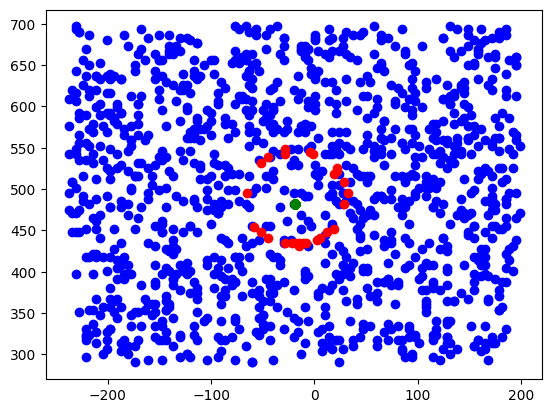

In [75]:
event = edf_d.loc[10124]
plt.scatter(event[event.signal == False]['x_c'], event[event.signal == False]['y_c'], c='b', marker='o')
plt.scatter(event[event.signal == True]['x_c'], event[event.signal == True]['y_c'], c='r', marker='o')
plt.scatter(event.x_i, event.y_i, c='g', marker='o')
plt.show()

In [65]:
print(bdf[round((bdf.momentum / bdf.beta * np.sqrt(1 - bdf.beta ** 2)), 2) == 139.57].shape[0] / bdf.shape[0])

1.0


In [118]:
group = 8
# bdf_group = bdf[bdf.param_group == group]
bdf_group = bdf_d
# Create the subplot layout: 2 rows, 3 columns
fig = make_subplots(
    rows=2, cols=3, 
    subplot_titles=("Histogram 1", "Histogram 2", "Histogram 3", "2D Histogram 1", "2D Histogram 2", "3D Scatter"),
    specs=[[{}, {}, {}], [{}, {}, {'type': 'scatter3d'}]], # Last subplot is 3D
)

# Subplot 1: Histogram
hist1 = go.Histogram(
    x=(bdf_group.momentum / bdf_group.beta_from_calc_r_4_rsigms_4_tsigms * np.sqrt(1 - bdf_group.beta_from_calc_r_4_rsigms_4_tsigms ** 2)).dropna()
)
fig.add_trace(hist1, row=1, col=1)

# Subplot 2: Histogram
# hist2 = go.Histogram(x=bdf_group.chi2)
# fig.add_trace(hist2, row=1, col=2)

fig.update_xaxes(type="log", row=1, col=2, range=[-10, 2])
fig.update_yaxes( row=1, col=2, range=[0, 1000])

# Subplot 3: Histogram
hist3 = go.Histogram(x=bdf_group.beta)
fig.add_trace(hist3, row=1, col=3)

# Subplot 4: 2D Histogram
hist2d_1 = go.Histogram2d(
    x=bdf_group.delta_beta_4_rsigms_4_tsigms, 
    y=bdf_group.beta,
    nbinsx=40, nbinsy=40,
    colorbar=dict(title="Colorbar 1", len=0.4, y=0.19, x=0.29)
)
fig.add_trace(hist2d_1, row=2, col=1)

# Subplot 5: 2D Histogram
hist2d_2 = go.Histogram2d(
    x=bdf_group.beta_from_calc_r_4_rsigms_4_tsigms, 
    y=bdf_group.beta,
    nbinsx=40, nbinsy=40,
    colorbar=dict(title="Colorbar 2", len=0.4, y=0.19, x=0.645)
)
fig.add_trace(hist2d_2, row=2, col=2)

line = go.Line(
    x=[0.965, 1],
    y=[0.965, 1],
)

fig.add_trace(line, row=2, col=2)

# Subplot 6: 3D Scatter plot
scatter3d = go.Scatter3d(
    x=bdf_group.unfixed_calculated_r_2d_4_rsigms_4_tsigms,
    y=bdf_group.theta_p,
    z=bdf_group.beta,
    mode='markers',
    marker=dict(size=1, color='red')
)
fig.add_trace(scatter3d, row=2, col=3)

# x = np.linspace(20, 70, 100)
# y = np.linspace(0, 0.8, 100)
# x, y = np.meshgrid(x, y)
# z = pol2_pol2((x, y), *cal_arr[0][0])
# 
# plane3d = go.Surface(x=x,
#                      y=y,
#                      z=z,
#                      opacity=0.7,
#                      colorscale='Viridis',
#                      colorbar=dict(title="Colorbar 3", len=0.4, y=0.19, x=0.97)
# )
# 
# fig.add_trace(plane3d, row=2, col=3)


# Update layout
fig.update_layout(
    height=800*1.8, width=1200*1.8,
    title_text="Multiple Subplots with Plotly",
    template="plotly_dark",
    showlegend=False
)

# Show plot
fig.show()

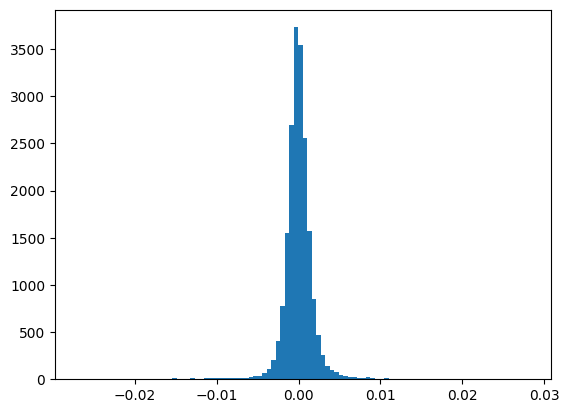

In [61]:
plt.hist(bdf.delta_beta_4_rsigms_4_tsigms, bins=100)
plt.show()

In [95]:
ф

NameError: name 'ф' is not defined

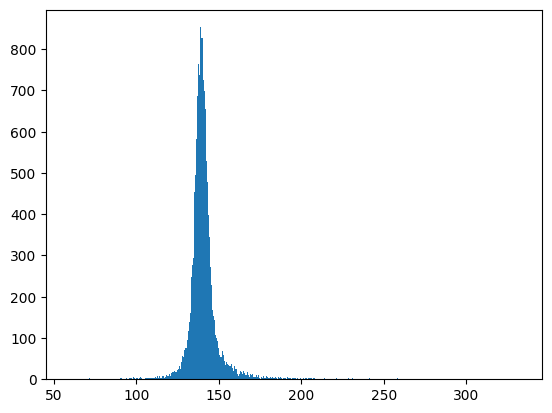

In [62]:
plt.hist((bdf.momentum / bdf.beta_from_calc_r_4_rsigms_4_tsigms * np.sqrt(1 - bdf.beta_from_calc_r_4_rsigms_4_tsigms ** 2)).dropna(), bins='auto')
plt.show()

In [81]:
edf

x_c     y_c        wv_c        r_c        x_i  \
entry subentry                                                         
0     0          89.440131  115.36  492.125984  21.769138  71.595397   
      1          62.560131  122.08  481.102362  21.209208  71.595397   
      2          96.160131  112.00  354.330709  26.199026  71.595397   
      3          62.560131   78.40  337.795276  26.105072  71.595397   
      4          99.520131  108.64  409.448819  28.510257  71.595397   
...                    ...     ...         ...        ...        ...   
19866 53         15.520131  723.52  321.259843  81.897746  75.526847   
      54          8.800131  683.20  359.842520  68.484226  75.526847   
      55        112.960131  622.72  425.984252  58.583862  75.526847   
      56         32.320131  622.72  486.614173  62.431070  75.526847   
      57         25.600131  629.44  343.307087  62.952247  75.526847   

                       y_i       t_c     z_c       true_p      beta  ...  \
entry subentry                                                       ...   
0     0         102.891606 -0.008724  2000.0   522.711615  0.966152  ...   
      1         102.891606 -0.004651  2000.0   522.711615  0.966152  ...   
      2         102.891606 -0.009171  2000.0   522.711615  0.966152  ...   
      3         102.891606  0.010254  2000.0   522.711615  0.966152  ...   
      4         102.891606 -0.008825  2000.0   522.711615  0.966152  ...   
...                    ...       ...     ...          ...       ...  ...   
19866 53        667.784600 -0.106859  2000.0  1272.214168  0.994036  ...   
      54        667.784600 -0.023338  2000.0  1272.214168  0.994036  ...   
      55        667.784600  0.079494  2000.0  1272.214168  0.994036  ...   
      56        667.784600  0.099267  2000.0  1272.214168  0.994036  ...   
      57        667.784600  0.086338  2000.0  1272.214168  0.994036  ...   

                      r_p_c  t_c_orig   theta_c     phi_c  rotated_theta_c  \
entry subentry                                                               
0     0         2003.924296 -3.955905  0.087283  0.073025         0.086818   
      1         2003.924296 -3.951150  0.096614 -0.161716         0.096100   
      2         2003.924296 -3.956724  0.087060  0.145913         0.086596   
      3         2003.924296 -3.934208  0.125796  0.044313         0.125129   
      4         2003.924296 -3.956500  0.088415  0.189049         0.087944   
...                     ...       ...       ...       ...              ...   
19866 53        2109.891129 -4.099791  0.446477 -0.127826         0.392031   
      54        2109.891129 -3.999161  0.480382 -0.123837         0.422880   
      55        2109.891129 -3.877545  0.518924  0.071893         0.458229   
      56        2109.891129 -3.855230  0.526319 -0.063628         0.465047   
      57        2109.891129 -3.870340  0.521725 -0.076705         0.460810   

                rotated_phi_c  signal_counts  param_group  \
entry subentry                                              
0     0              1.035897           10.0          1.0   
      1              0.801156           10.0          1.0   
      2              1.108785           10.0          1.0   
      3              1.007185           10.0          1.0   
      4              1.151921           10.0          1.0   
...                       ...            ...          ...   
19866 53             1.330348           58.0         10.0   
      54             1.334337           58.0         10.0   
      55             1.530067           58.0         10.0   
      56             1.394546           58.0         10.0   
      57             1.381469           58.0         10.0   

                slice_counts_4_sigms  \
entry subentry                         
0     0                     0.028769   
      1                     0.028769   
      2                     0.000000   
      3                     0.000000   
      4                     0.000000   
...     

In [69]:
plt.rcParams['font.size'] = 22

In [67]:
bdf_test = bdf.drop(bdf.sample(frac=0.8, random_state=42).index)

In [79]:
bdf.delta_beta_4_rsigms_4_tsigms = bdf.beta_from_calc_r_4_rsigms_4_tsigms - bdf.beta

In [68]:
beta_sigms = []
beta_sigms_yerr = []

In [69]:
bg = betaGroupsRMS90(bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
beta_sigms.append(bg[0])
beta_sigms_yerr.append(bg[2])

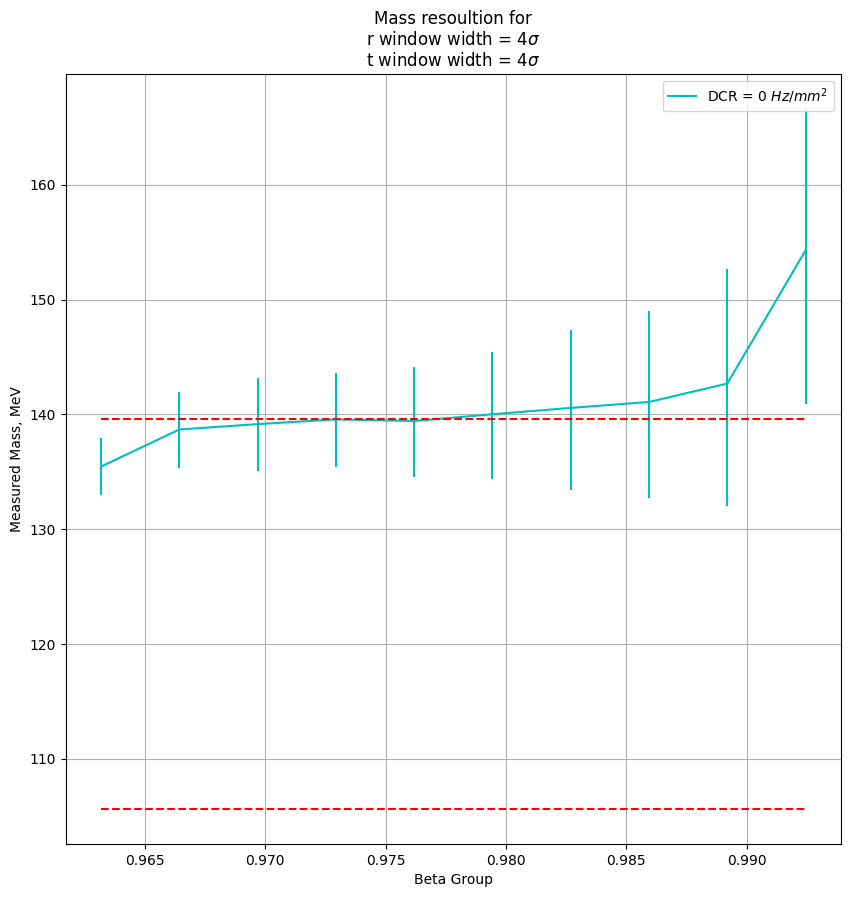

In [70]:
plot_final_mass_graph(edf, bg[3], bg[4], bg[5], avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, to_save=False, deg_lim=False, num_of_groups=num_of_groups, iteration=0)

In [52]:
beta_sigms = np.array(beta_sigms)
beta_sigms_yerr = np.array(beta_sigms_yerr)

In [53]:
plot_final_graph(edf_d, beta_sigms, beta_sigms_yerr, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, labels=['0', '1e3', '1e4', '1e5', '1e6'], deg_lim=False, num_of_groups=num_of_groups, iteration=0)

In [76]:
edf_d = edf[edf.theta_p <= 10. * np.pi / 180]
edf_d = edf_d[edf_d.signal_counts >= 5]
bdf_d = bdf[bdf.theta_p <= 10. * np.pi / 180]
bdf_d = bdf_d[bdf_d.signal_counts >= 5]

In [77]:
bg_deglim = betaGroupsRMS90(bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, n=num_of_groups)
beta_sigms_deglim.append(bg_deglim[0])
beta_sigms_yerr_deglim.append(bg_deglim[2])

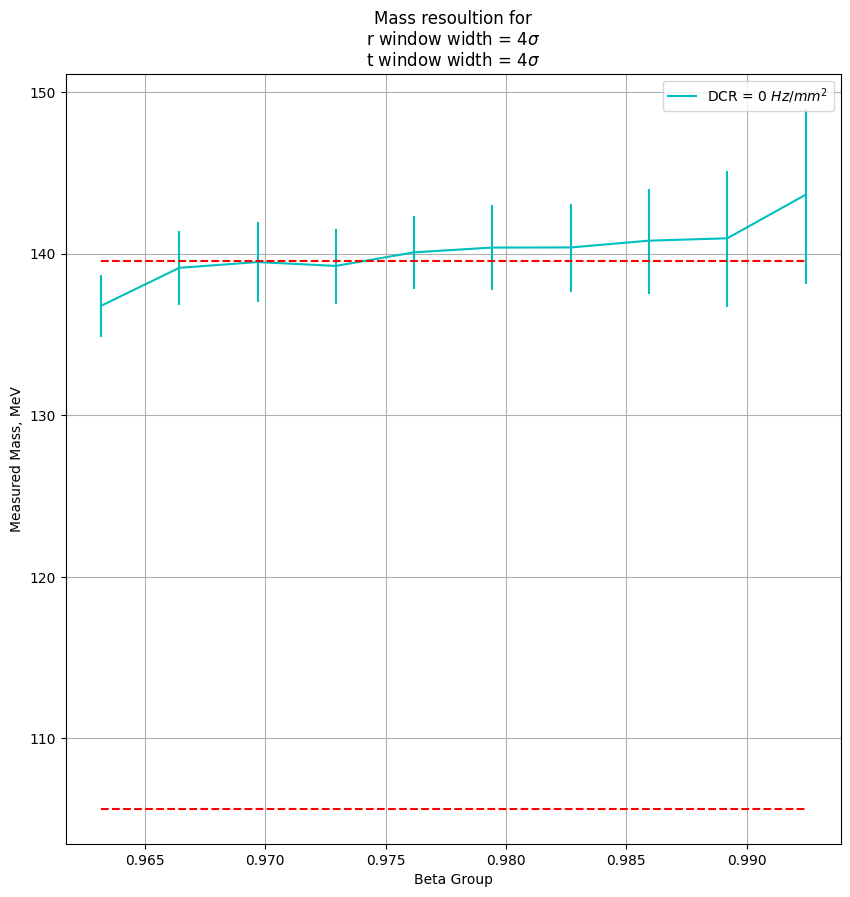

In [78]:
plot_final_mass_graph(edf, bg_deglim[3], bg_deglim[4], bg_deglim[5], avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, to_save=False, deg_lim=True, num_of_groups=num_of_groups, iteration=0)

In [79]:
beta_sigms_deglim = np.array(beta_sigms_deglim)
beta_sigms_yerr_deglim = np.array(beta_sigms_yerr_deglim)

In [80]:
plot_final_graph(edf, beta_sigms_deglim, beta_sigms_yerr_deglim, avg_sigmas, avg_t_sigmas, r_width, t_width, r_factor, t_factor, weighed, deg_lim=True, num_of_groups=num_of_groups, iteration=0)

# End of main